In [1]:
using PyPlot
using LaTeXStrings: @L_str

In [2]:
include("../RungeKutta/src/RungeKutta.jl")
using RungeKutta

In [3]:
include("equations.jl")

dstiff1 (generic function with 1 method)

## Оценка глобальных погрешностей с помощью уравнения линейного осциллятора

Для оценки глобальной погрешности полностью неявных методов Рунге--Кутты воспользуе6мся системой уравнений для линейного осциллятора. Это простейшая система уравнений имеет точное аналитическое решение, что позволит оценить погрешность численных схем.

Для применения IRK методов необходимо задать правую часть системы уравнений и матрицу Якоби от правой части. В случае линейного осциллятора матрица Якоби постоянна.
\begin{equation}
    \left\{
        \begin{aligned}
            &\dot{x}_{1} = -x_{2},\\
            &\dot{x}_{2} = x_{1},
        \end{aligned}
    \right.
    \quad
    J(x_1, x_2) = 
    \begin{pmatrix}
        0 & -1 \\
        1 & 0
    \end{pmatrix}
\end{equation}
Аналитическое решение имеет следующий вид:
\begin{equation}
    \left\{
        \begin{aligned}
            &x_1(t) = x_{01}\cos{t} - x_{02}\sin{t},\\
            &x_2(t) = x_{02}\cos{t} + x_{01}\sin{t}.
        \end{aligned}
    \right.
\end{equation}

In [4]:
x_0 = init_values["осциллятор"].x_0
t_0 = init_values["осциллятор"].t_0
t_N = init_values["осциллятор"].t_N
@show x_0, t_0, t_N
A_tol = 1.0e-6
R_tol = 1.0e-6
method = "ROS3PRL" # "GRK4A" # "GRK4T"
x_0

(x_0, t_0, t_N) = ([1.0, 1.0], 0.0, 60.0)


2-element Array{Float64,1}:
 1.0
 1.0

Погрешность для $n$-го шага вычисляется по следующей формуле:
$$
    \varepsilon_{n} = \| \mathbf{x}(t_n) - \mathbf{x}_n\| = \sqrt{(x_1(t_n) - x_{1n})^2 + (x_2(t_n) - x_{2n})^2},
$$
где $\mathbf{x}(t) = (x_1(t), x_2(t))^T$ --- точное аналитическое решение, $\mathbf{x}_n = (x_{1n}, x_{2n})^T$ --- численное решение, полученное для $n$-го шага. Вычисляя $\varepsilon_n$ для всех $n$ получим массив чисел. После чего можно построить график $(t_n, \varepsilon_n)$. По оси $Oy$ выберем логорифмический масштаб, а по оси $Ox$ --- обычный линейный.

In [5]:
tn, xn = RRK.GRK4A(oscillator, oscillator_df, oscillator_jacobi, x_0, t_0, t_N, A_tol, R_tol)
X = hcat([oscillator_solution(t, x_0) for t in tn]...)
err = [norm(X[:, i] - xn[:, i]) for i in 1:length(tn)];

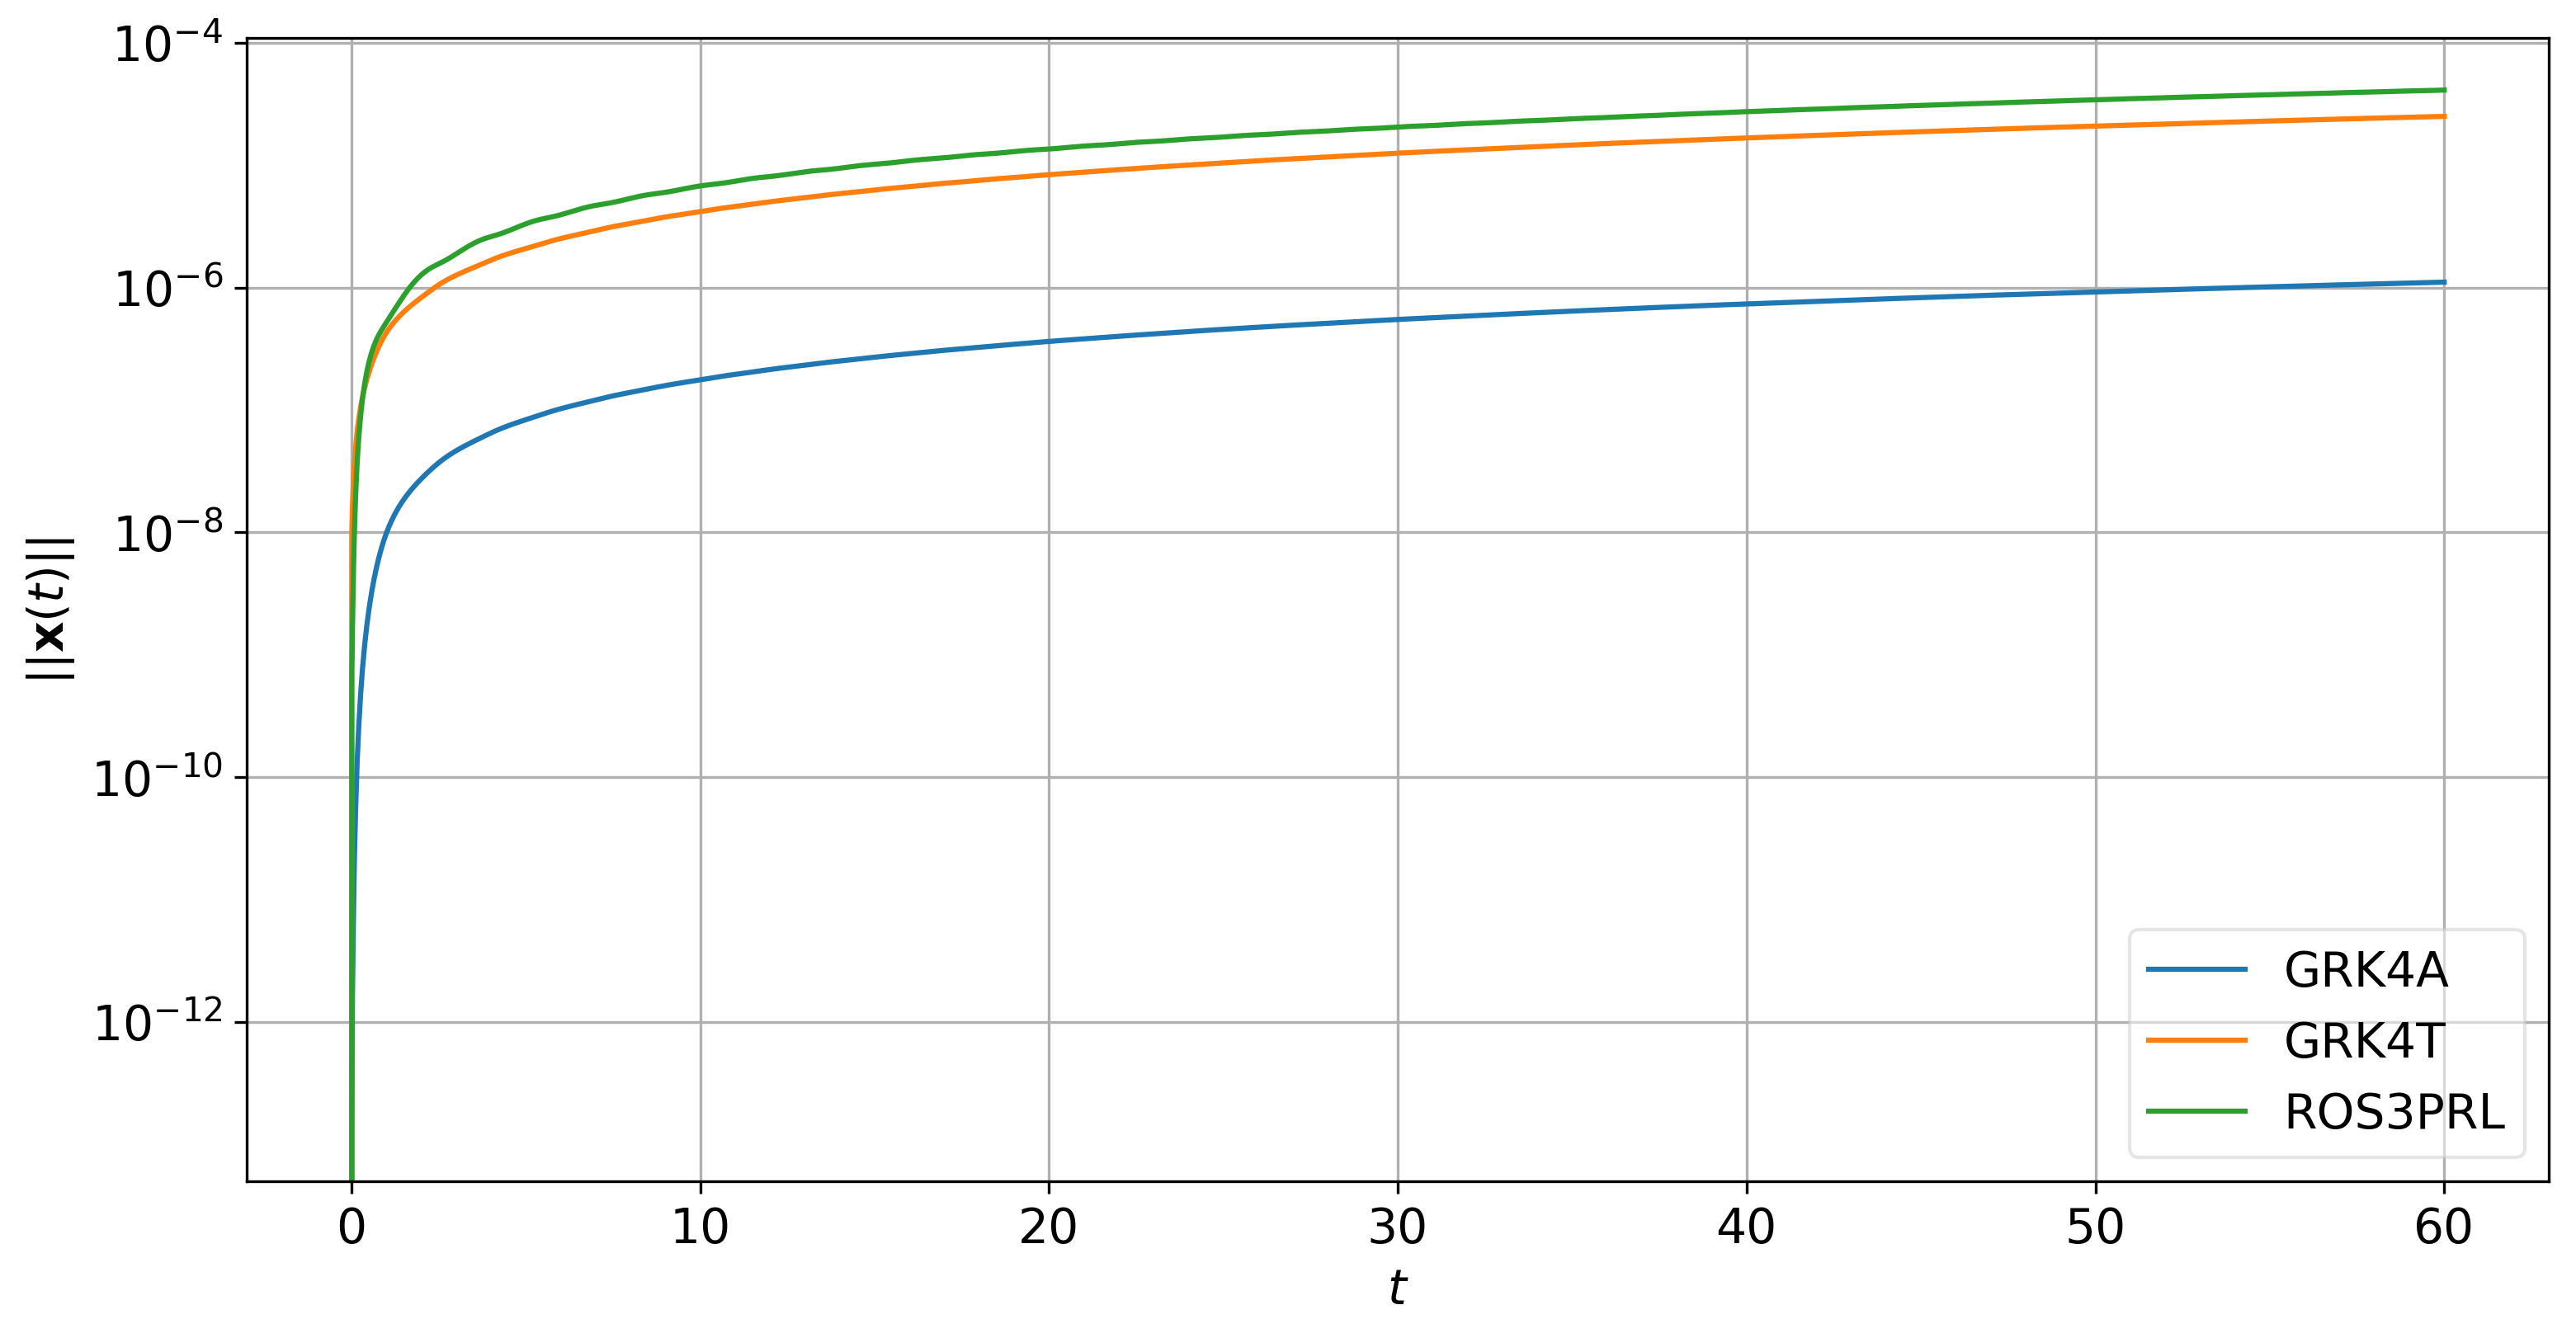

PyObject Text(93,0.5,'$\\||\\mathbf{x}(t)\\||$')

In [6]:
fig01 = PyPlot.figure(1, dpi=300, figsize=(12.0, 6.0))
ax01 = fig01[:add_subplot](1, 1, 1)

ax01[:set_yscale]("log")

for method in RRK.functions
    tn, xn = RRK.eval(method)(oscillator, oscillator_df, oscillator_jacobi, x_0, t_0, t_N, A_tol, R_tol)
    X = hcat([oscillator_solution(t, x_0) for t in tn]...)
    err = [norm(X[:, i] - xn[:, i]) for i in 1:length(tn)]
    ax01[:plot](tn, err, linewidth=1.5, label="$method")
end
ax01[:grid](true)
ax01[:set_yscale]("log")
ax01[:legend](loc="best", framealpha=0.5)
ax01[:set_xlabel](L"$t$")
ax01[:set_ylabel](L"$\||\mathbf{x}(t)\||$") 

## Жесткая система ОДУ: реакция Робертсона

Жесткая система ОДУ. Описывает автокаталлическую реакцию Робертсона. Детали описания см по [ссылке](http://www.radford.edu/~thompson/vodef90web/problems/demosnodislin/Single/DemoRobertson/demorobertson.pdf)
\begin{equation}
    \left\{
    \begin{aligned}
        & \dot{x}_{1}(t) = -k_1 x_1 + k_3 x_2 x_3,\\
        & \dot{x}_{2}(t) = k_1 x_1 - k_2 x^2_2 - k_3 x_2 x_3\\
        & \dot{x}_{3}(t) = k_2 x_2^2,
    \end{aligned}
    \right.
\end{equation}

Многие численные методы несправляются с интегрированием данной системы при условии большого временного промежудка и при следующих значениях коэффициентов:
$$k_1 = 0.04,\;k_2 = 3\cdot 10^7\; k_3 = 10^4,$$
$$\mathbf{x} = (1, 0, 0)^T,\; t = [0, 10^{11}].$$

Так как текущая реализация неявных методов Рунге--Кутты сохраняет все вычисленные значения в массив, а для интегрирования требуется малый шаг, то программа падает из-за нехватки памяти. Поэтому возьмем малый промежуток времени, а в дальнейшем переделаем программу.

In [7]:
x_0 = init_values["Робертсон"].x_0
t_0 = init_values["Робертсон"].t_0
t_N = init_values["Робертсон"].t_N
@show x_0, t_0, t_N

(x_0, t_0, t_N) = ([1.0, 0.0, 0.0], 0.0, 100000.0)


([1.0, 0.0, 0.0], 0.0, 100000.0)

In [19]:
# Начальные данные из книги Хайрера 2-й том
R_tol = 1.0e-3
A_tol = 1.0e-6

1.0e-6

In [20]:
tn, xn = RRK.GRK4A(robertson, robertson, robertson_jacobi, x_0, t_0, 1e6, A_tol, R_tol)

([0.0, 0.00168375, 0.00232193, 0.00269309, 0.00298522, 0.00328536, 0.00357065, 0.00386345, 0.00415911, 0.00446608  …  9.99986e5, 9.99987e5, 9.99989e5, 9.99991e5, 9.99993e5, 9.99995e5, 9.99996e5, 9.99998e5, 1.0e6, 1.0e6], [1.0 0.999933 … -1105.13 -1105.13; 0.0 -3.09418e-6 … -3.21769e-6 -3.2848e-6; 0.0 7.04964e-5 … 1034.37 1034.37])

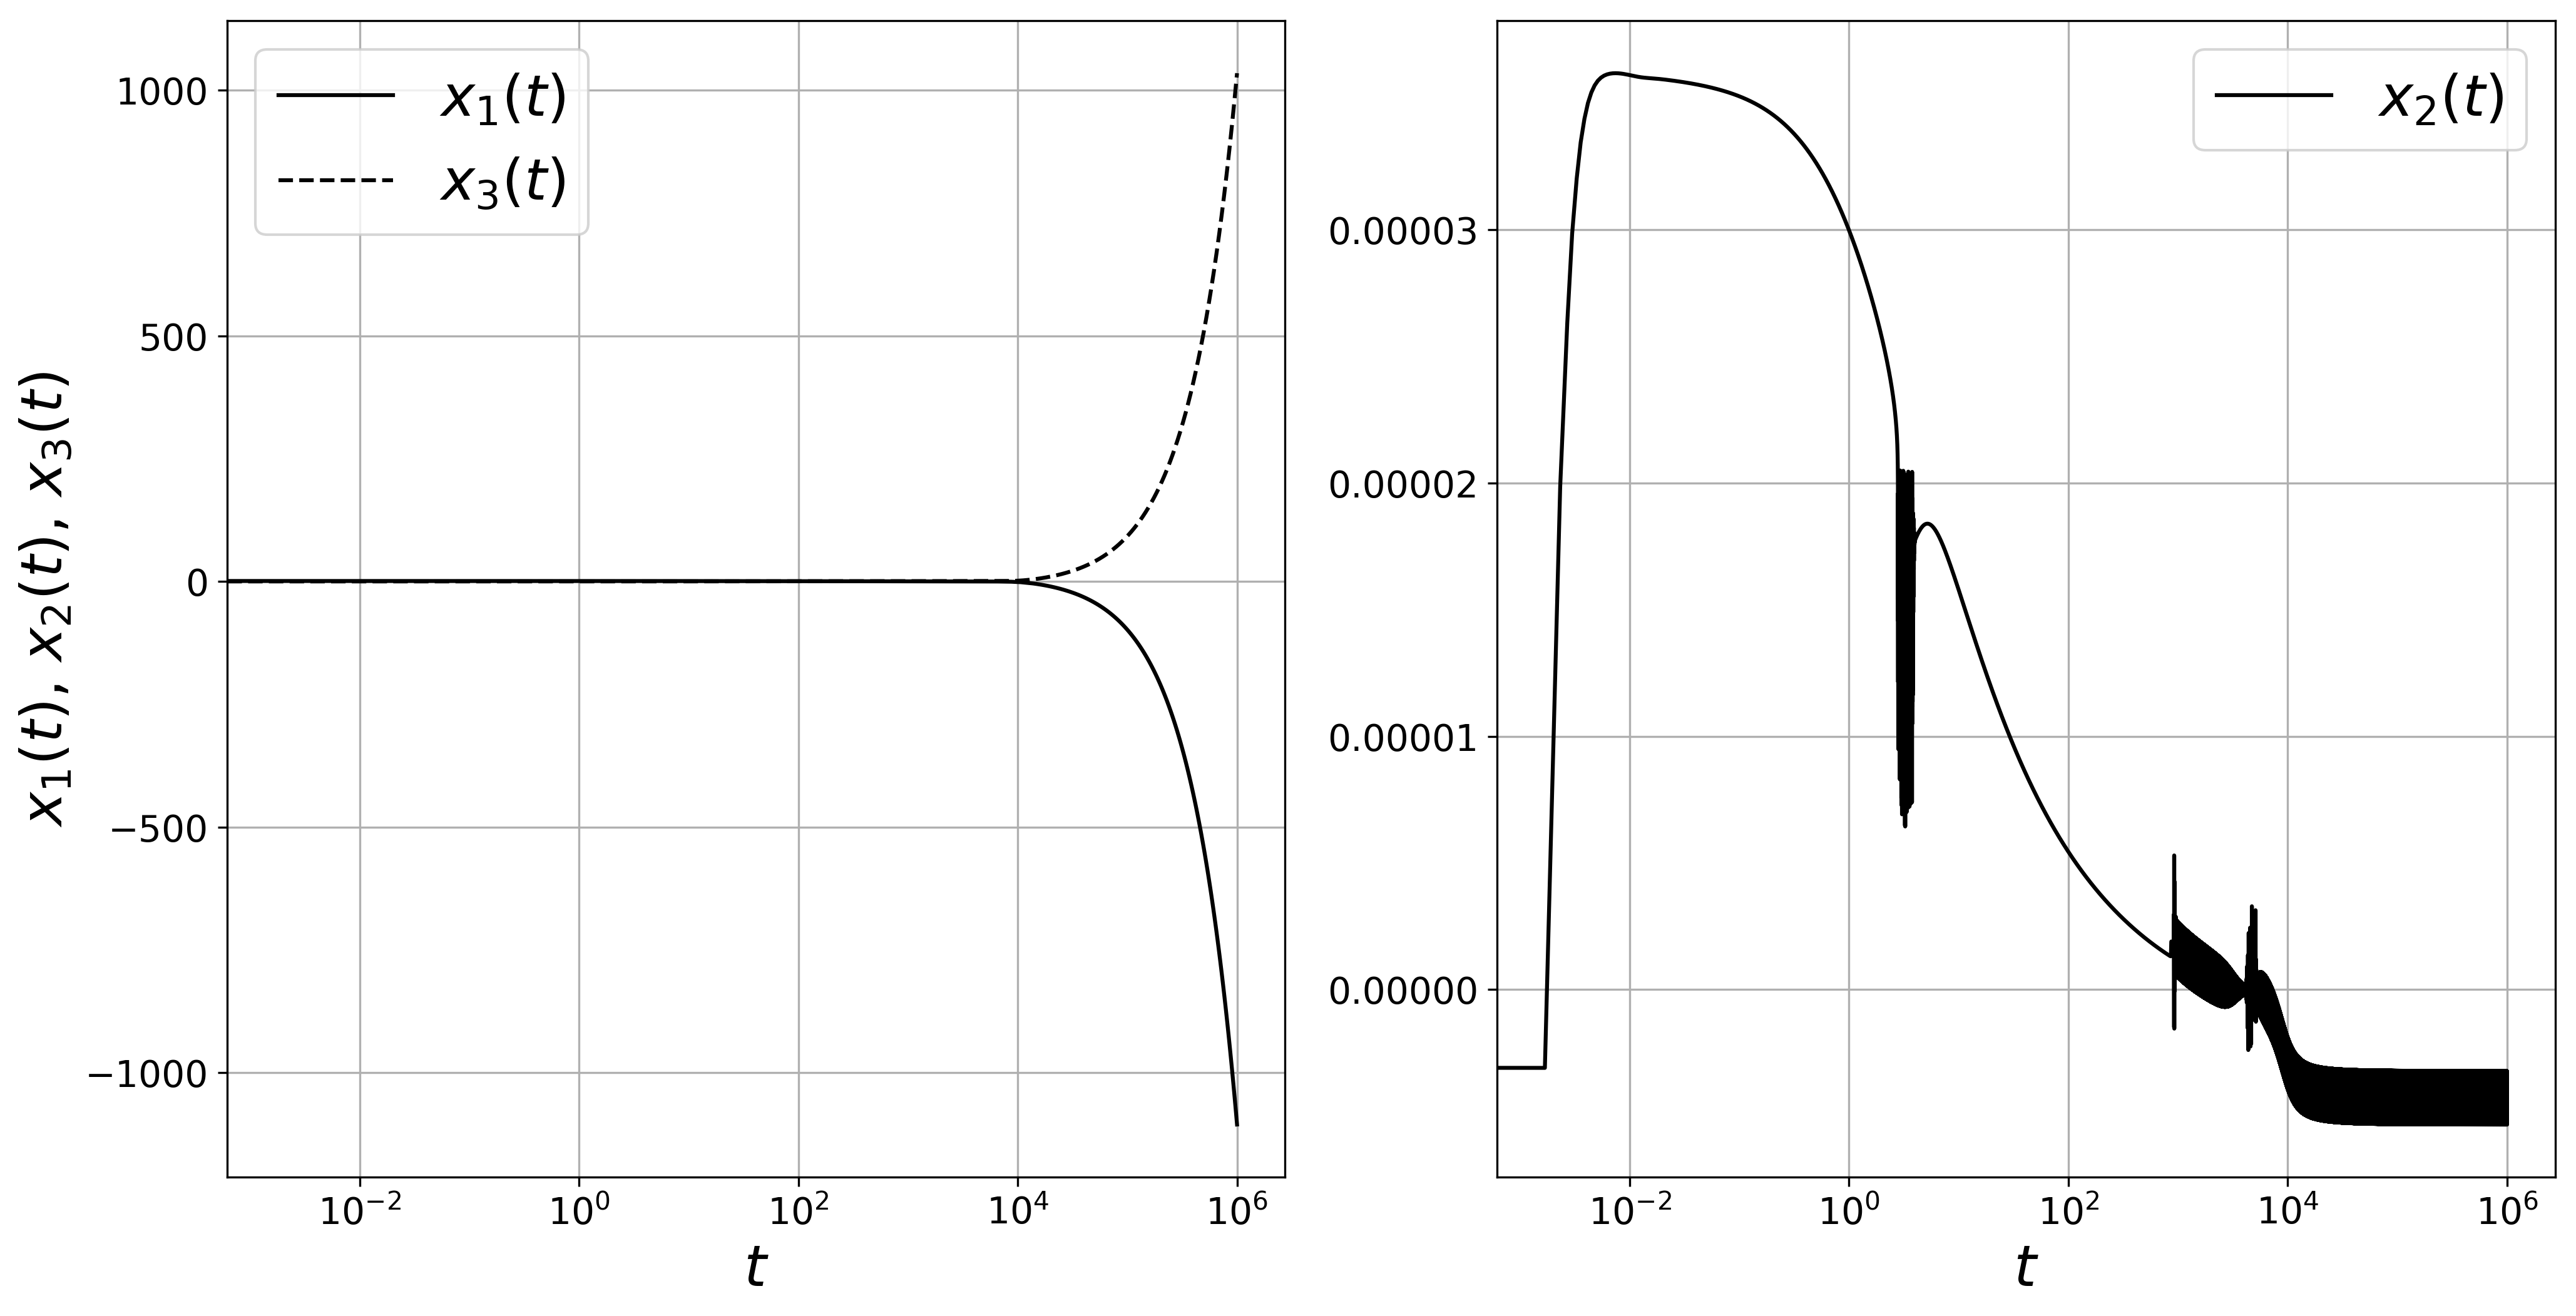

PyObject <matplotlib.legend.Legend object at 0x7f68e5f98eb8>

In [21]:
fig03 = PyPlot.figure(num=9, dpi=300, figsize=(16, 8))

ax031 = fig03[:add_subplot](1, 2, 1)
ax032 = fig03[:add_subplot](1, 2, 2)

ax031[:set_xscale]("log")
ax032[:set_xscale]("log")

ax031[:plot](tn, xn[1,:], ls="-", color="k", label=L"$x_1(t)$")
ax032[:plot](tn, xn[2,:], ls="-", color="k", label=L"$x_2(t)$")
ax031[:plot](tn, xn[3,:], ls="--", color="k", label=L"$x_3(t)$")

ax031[:set_xlabel](L"$t$", fontsize=22)
ax032[:set_xlabel](L"$t$", fontsize=22)

ax031[:set_ylabel](L"$x_1(t)$, $x_2(t)$, $x_3(t)$", fontsize=22)
ax031[:grid](true)
ax032[:grid](true)
ax031[:legend](loc="best", fontsize=22)
ax032[:legend](loc="best", fontsize=22)